In [361]:
from sklearn.datasets import load_diabetes, load_wine
from fastloocv import FastLOOCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data = load_wine()
print(len(data["data"]))

178


In [3]:
model = FastLOOCV(data)
k_values = [k for k in range(1, 26)]

scores, time = model.do_normal_loocv(k_values=k_values, sample_size=None)
scores2, time2 = model.do_fast_loocv(k_values=k_values, sample_size=None)

LOOCV:
Best k: 12, Score: 0.26029962546816493
time: 1.0683300495147705s
---------------------------------------------
Fast LOOCV:
Best k: 12, Score: 0.2602996254681649
time: 0.45244526863098145s


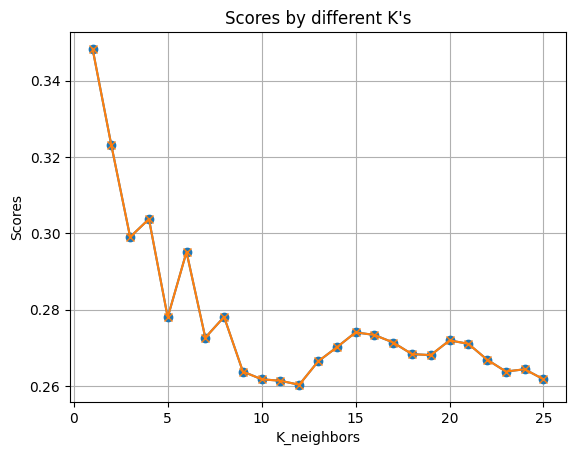

In [4]:
print("LOOCV:")
print(f"Best k: {k_values[np.argmin(scores)]}, Score: {scores[np.argmin(scores)]}")
print(f"time: {time}s")
print("---"*15)
print("Fast LOOCV:")
print(f"Best k: {k_values[np.argmin(scores2)]}, Score: {scores2[np.argmin(scores2)]}")
print(f"time: {time2}s")

plt.plot(k_values, scores, marker='o', linestyle='-')
plt.plot(k_values, scores2, marker='x')

plt.xticks(np.arange(0, 30, 5))
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y') 
plt.title("Scores by different K's")
plt.xlabel("K_neighbors")
plt.ylabel("Scores")
plt.show()

In [515]:
df = pd.read_csv('performance.csv')
df.drop(['GradeClass'], axis=1, inplace=True)
print(df.shape)

(2392, 14)


In [ ]:
correlation = abs(df.corr()["GPA"])
print(correlation.sort_values(ascending=False))
important_variables = correlation[correlation >= 0.1]
print(f"Chosen the following variables: {important_variables.index.to_list()}")

GPA                  1.000000
Absences             0.919314
ParentalSupport      0.190774
StudyTimeWeekly      0.179275
Tutoring             0.145119
Extracurricular      0.094078
Music                0.073318
Sports               0.057859
ParentalEducation    0.035854
Ethnicity            0.027760
Gender               0.013360
Volunteering         0.003258
StudentID            0.002697
Age                  0.000275
Name: GPA, dtype: float64
Chosen the following variables: ['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'GPA']


In [518]:
new_df = df[important_variables.index.to_list()].copy()

# Adapting GPA to french grading
new_df['GPA'] = new_df['GPA'].astype(float) * 5


X = new_df.drop(columns=['GPA'])
y = new_df['GPA']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) 
data = {'data': X_scaled,
        'target': y}

k_values = [k for k in range(1, 50)]
model = FastLOOCV(data)

scores, times  = model.do_fast_loocv(k_values=k_values, sample_size=None)
print(f"The best k found during training is: {k_values[np.argmin(scores)]}")


print("--"*30)
print("Evaluating the model & Visualizing predictions and real values")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

knn = KNeighborsRegressor(n_neighbors=k_values[np.argmin(scores2)])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


The best k found during training is: 15
------------------------------------------------------------
Evaluating the model & Visualizing predictions and real values
MSE: 1.88
R²: 0.91


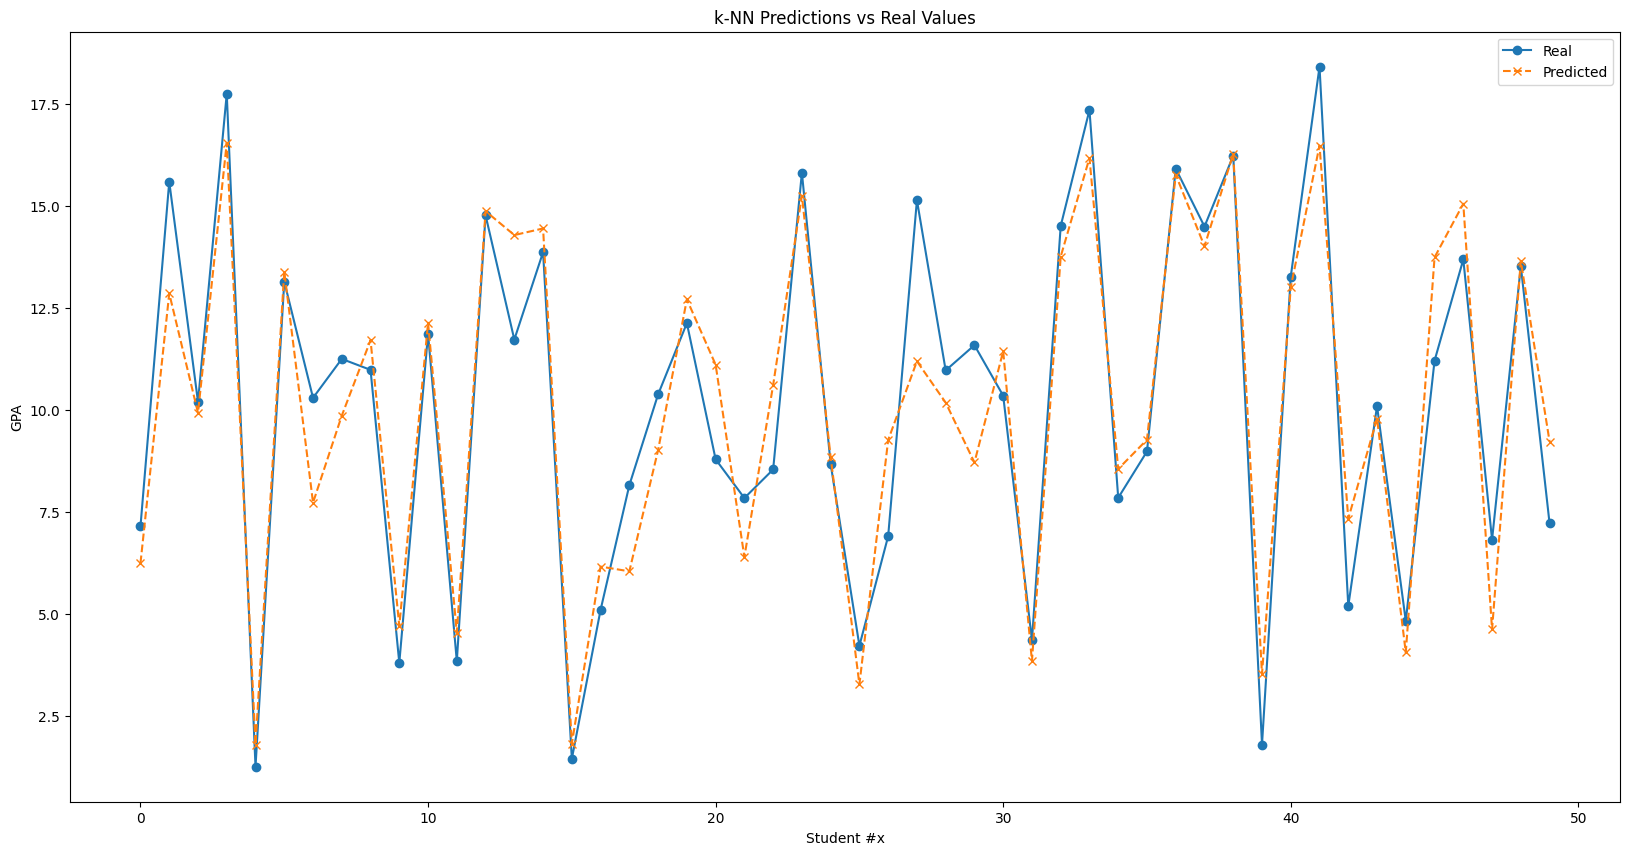

In [512]:

x_axis = list(range(len(y_pred)))

visualize_num = 50

plt.figure(figsize=(20,10))

plt.plot(x_axis[:visualize_num], y_test[:visualize_num], marker='o', label='Real')
plt.plot(x_axis[:visualize_num], y_pred[:visualize_num], marker='x', label='Predicted', linestyle='--')

plt.xlabel('Student #x')
plt.ylabel('GPA')
plt.title('k-NN Predictions vs Real Values')
plt.legend()
plt.show()

In [ ]:
# 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport'
print("Playing with the model:")
while True:
    study_per_week = int(input("How many hours did you study per week"))
    absences = int(input("How many times you have been absent"))
    tutoring = int(input("Do you have tutoring (0:no 1:yes)"))
    p_support = int(input("How much support you have from your parents (0low, 4 high)"))
    features = scaler.transform([[study_per_week, absences,tutoring, p_support]])
    print(f"Your expected grade is: {round(knn.predict(features)[0], 2)}/20")
    x = input("Press e to exit or whatever to continue")
    if x == 'e':
        break
    